In [1]:
import pandas as pd
import torch
import torch.nn as nn
import random
from tqdm.notebook import tqdm

In [2]:
interactions_train = pd.read_csv("/content/interactions_train.csv")
interactions_test = pd.read_csv('/content/interactions_test.csv')
interactions = pd.concat([interactions_train, interactions_test], ignore_index=True)

In [3]:
# Tous les indices de lignes de toutes les données
all_index = set(interactions.index.values)
# On tire au hasard 25% de toutes les lignes qui constitueront les données de test
index_test = random.sample(range(len(interactions)), int(len(interactions)*0.25))
# Index des données de train (= différence entre tous les index et les index de test)
index_train = list(all_index.difference(set(index_test)))

interactions_train = interactions.iloc[index_train]
interactions_test = interactions.iloc[index_test]

In [4]:
# Pour les données de test, on garde seulement ceux dont les user_id et les recipe_id sont dans les données de train
index_to_keep = list(interactions_test.loc[(interactions_test['user_id'].isin(interactions_train['user_id'])) & (interactions_test['recipe_id'].isin(interactions_train['recipe_id']))].index.values)
# Et on remet ceux qui ne satisfont pas la condition dans les données de train
index_to_move_to_train = set(index_test).difference(set(index_to_keep))
# Index finaux des données de train
all_index_train = index_train + list(index_to_move_to_train)

interactions_test = interactions.iloc[index_to_keep]
interactions_train = interactions.iloc[all_index_train]

In [5]:
print("Pourcentage de données de test :", len(interactions_test) * 100 / (len(interactions_train) + len(interactions_test)))

Pourcentage de données de test : 21.469278392253667


In [6]:
from torch.utils.data import Dataset, DataLoader

class Ratings_Dataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index()
        user_list = df['user_id'].unique()
        item_list = df['recipe_id'].unique()
        self.user2id = {w: i for i, w in enumerate(user_list)}
        self.item2id = {w: i for i, w in enumerate(item_list)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = self.user2id[self.df['user_id'][idx]]
        user = torch.tensor(user, dtype=torch.long)
        item = self.item2id[self.df['recipe_id'][idx]]
        item = torch.tensor(item, dtype=torch.long)
        rating = torch.tensor(self.df['rating'][idx], dtype=torch.float)
        return user, item, rating

trainloader = DataLoader(Ratings_Dataset(interactions_train), batch_size=512, shuffle=True ,num_workers=2)
testloader = DataLoader(Ratings_Dataset(interactions_test), batch_size=64, num_workers=2)

In [7]:
class NCF(nn.Module):

    def __init__(self, n_users, n_items, n_factors=8):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors)
        self.predictor = torch.nn.Sequential(
            nn.Linear(in_features=n_factors*2, out_features=64),
            nn.Linear(in_features=64, out_features=32),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, user, item):
        u = self.user_embeddings(user)
        i = self.item_embeddings(item)

        # Concat the two embedding layers
        z = torch.cat([u, i], dim=-1)
        return self.predictor(z)

In [8]:
from statistics import mean

def train(model, optimizer, trainloader, epochs=30):
    criterion = nn.MSELoss(reduction='mean')
    t = tqdm(range(epochs))
    for epoch in t:
        corrects = 0
        total = 0
        train_loss = []
        for users, items, r in trainloader:
            users = users.cuda()
            items = items.cuda()
            r = r.cuda() / 5
            y_hat = model(users, items)
            loss = criterion(y_hat, r.unsqueeze(1).float())
            train_loss.append(loss.item())
            total += r.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f"loss: {mean(train_loss)}")

def test(model, testloader, m_eval=False):
    running_mae = 0
    with torch.no_grad():
        corrects = 0
        total = 0
        for users, items, r in testloader:
            users = users.cuda()
            items = items.cuda()
            y = r.cuda() / 5
            y_hat = model(users, items).flatten()
            error = torch.abs(y_hat - y).sum().data

            running_mae += error
            total += y.size(0)

    mae = running_mae/total
    return mae * 5

In [10]:
n_user = interactions_train.user_id.nunique()
n_items = interactions_train.recipe_id.nunique()

model = NCF(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
test(model, testloader)

tensor(0.7098, device='cuda:0')

In [12]:
users, items, r = next(iter(testloader))
users = users.cuda()
items = items.cuda()
r = r.cuda()

y = model(users, items)*5
print("ratings", r[:20].data)
print("predictions:", y.flatten()[:20].data)

ratings tensor([5., 5., 5., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        4., 5.], device='cuda:0')
predictions: tensor([4.9217, 4.5633, 4.2483, 4.6407, 4.8629, 4.4593, 4.4706, 4.3023, 4.6859,
        4.9226, 4.6406, 4.1471, 4.6841, 3.7174, 4.8529, 3.9618, 4.8120, 4.5839,
        4.6884, 4.7921], device='cuda:0')


(array([ 2.,  4.,  2.,  2.,  2.,  5.,  9., 11., 14., 13.]),
 array([2.85377717, 3.06065917, 3.26754117, 3.47442317, 3.68130517,
        3.88818693, 4.09506893, 4.30195093, 4.50883293, 4.71571493,
        4.92259693]),
 <BarContainer object of 10 artists>)

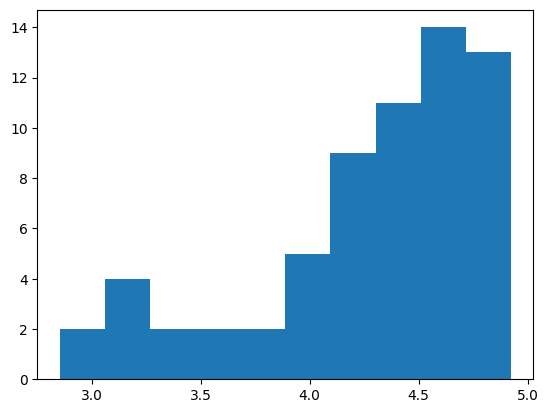

In [13]:
import matplotlib.pyplot as plt

plt.hist(y.flatten().cpu().detach().numpy())

# Entraînement sur toutes les données

In [14]:
n_user = interactions.user_id.nunique()
n_items = interactions.recipe_id.nunique()

model = NCF(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

In [16]:
torch.save(model.state_dict(), "weight.pth")